# **This notebook can be used to plot radar plots**
- similar to published here: https://pubmed.ncbi.nlm.nih.gov/35390365/

**What are the inputs necessary to run this notebook?**
- Use a csv with features from CellProfiler as input
- Have the Metadata features starting with "Metadata_" prefix
        
## Steps:

1. Prepare a csv with features
2. Group the features up to the level you want to show them (e.g. compound+dose)
3. Choose the information to plot
4. Calculate correlations
5. Visualize!

# **1. Import libraries and decide on plot settings**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("white")
import plotly.graph_objects as go
import math

%matplotlib inline

In [2]:
# format for saving images
figformat = 'png'
dpi = 150
cmap = "viridis"

# **2. Define inputs and outputs**

In [3]:
# Set current working directory
print(os.getcwd())

/home/jovyan/jonne/Feature_Analysis/radarplots


In [4]:
# set output directory
OutputDir = "./radarplots/" 
if not os.path.exists(OutputDir):
    os.makedirs(OutputDir)

In [5]:
# Import feature data in csv format 

input_file = "input/example_features.csv"

file_extension = os.path.splitext(input_file)[1]
if file_extension == '.csv':
    features_df = pd.read_csv(input_file)
elif file_extension == '.parquet':
    features_df = pd.read_parquet(input_file)
else:
    raise ValueError(f"Unsupported file format: {file_extension}")

features_df.columns = features_df.columns.str.lower()
features_df.head(2)

,metadata_plate_map_name,metadata_cmpdname,metadata_cmpdconc,metadata_cellline,metadata_cmpdanddose,nuclei_areashape_boundingboxmaximum_y,nuclei_areashape_boundingboxminimum_x,nuclei_areashape_orientation,nuclei_areashape_zernike_1_1,nuclei_areashape_zernike_2_2,...,cells_radialdistribution_zernikephase_rna_8_0,cells_radialdistribution_zernikephase_rna_8_2,cells_radialdistribution_zernikephase_rna_8_4,cells_radialdistribution_zernikephase_rna_8_6,cells_radialdistribution_zernikephase_rna_8_8,cells_radialdistribution_zernikephase_rna_9_1,cells_radialdistribution_zernikephase_rna_9_3,cells_radialdistribution_zernikephase_rna_9_5,cells_radialdistribution_zernikephase_rna_9_7,cells_radialdistribution_zernikephase_rna_9_9
0,cp-water-plate1,berb,10.0,A549,berb_10.0,0.044895,-0.009243,-0.048671,-0.835916,1.002293,...,1.691670,-0.220968,-0.349213,-0.303566,0.180300,0.081813,0.281209,0.091430,0.011454,0.347890
1,cp-water-plate1,berb,10.0,CHOK1,berb_10.0,-0.190794,-0.338917,-0.228219,0.423596,-0.216053,...,-0.342266,-0.141182,-0.270911,-0.070788,0.248468,-0.155404,-0.168029,-0.127061,0.091744,-0.214845


In [6]:
def dropdown(input_list, multiple=False):
    import ipywidgets as widgets
    global dropdown_output

    if multiple:
        # Use SelectMultiple for multiple selections
        widget = widgets.SelectMultiple(
            options=input_list,
            description='Choose',
            disabled=False
        )
    else:
        # Use Dropdown for a single selection
        widget = widgets.Dropdown(
            options=input_list,
            description='Choose',
            disabled=False
        )

    def dropdown_handler(change):
        global dropdown_output
        dropdown_output = change.new

    widget.observe(dropdown_handler, names='value')
    display(widget)
    dropdown_output = widget.value


# **3. group features**

In [8]:
# Load grouping file 
grouping = pd.read_csv('input/CP_Features_grouping.csv', sep=',', index_col=1) 
grouping = grouping['CHAN-MOD_biorelevant_38cat'].to_frame()
grouping.head(2)

,CHAN-MOD_biorelevant_38cat
Feature_name_2,
cells_areashape_area,AreaShape_cells
cells_areashape_boundingboxarea,AreaShape_cells


In [9]:
# Remove non-data features from the list
ListOfFeatures = list(features_df.columns[~features_df.columns.str.contains("metadata_")])
ListOfMetadata = list(features_df.columns[features_df.columns.str.contains("metadata_")])

In [13]:
print("Number of features in the grouping file: {}".format(len(grouping)))
print("Number of features in the provided data file: {}".format(len(features_df.columns)))

missing_features = []

for feature in grouping.index:
    if feature not in features_df.columns:
        missing_features.append(feature)

print("The number of features missing in the feature list is: {}".format(len(missing_features)))

Number of features in the grouping file: 2104
Number of features in the provided data file: 1514
The number of features missing in the feature list is: 598


# **4. select grouping for radar plot (e.g. compound)**

In [14]:
# What level do you want to group your features on?
meta_list = [option for option in features_df.filter(regex=r'metadata', axis=1).columns]

dropdown(meta_list, multiple=False)

Dropdown(description='Choose', options=('metadata_plate_map_name', 'metadata_cmpdname', 'metadata_cmpdconc', '…

In [15]:
grouping_col = dropdown_output
print("we will group your features on the:", grouping_col, "feature")

we will group your features on the: metadata_cmpdname feature


In [16]:
conditions_list = features_df[grouping_col].unique()
dropdown(conditions_list, multiple=True)

SelectMultiple(description='Choose', options=('berb', 'etop', 'fenb', 'noco'), value=())

In [17]:
selected_conditions = dropdown_output
print("we will plot radarplots for:", selected_conditions)

we will plot radarplots for: ('berb', 'etop', 'fenb', 'noco')


# **5. what is a secondary grouping factor (levels/traces within one radar plot)**

In [18]:
# What level do you want to group your features on?
meta_list = [option for option in features_df.filter(regex=r'metadata', axis=1).columns]

dropdown(meta_list, multiple=False)

Dropdown(description='Choose', options=('metadata_plate_map_name', 'metadata_cmpdname', 'metadata_cmpdconc', '…

In [19]:
secondary_grouping_col = dropdown_output
print("we will plot:", secondary_grouping_col, "as traces in your radar plot")

we will plot: metadata_cmpdconc as traces in your radar plot


In [20]:
secondary_conditions_list = features_df[secondary_grouping_col].unique()
dropdown(secondary_conditions_list, multiple=True)

SelectMultiple(description='Choose', options=(10.0, 0.01, 0.1, 1.0), value=())

In [21]:
selected_secondary_conditions = dropdown_output
print("we will plot radarplots for", secondary_grouping_col, "in selected ", selected_secondary_conditions)

we will plot radarplots for metadata_cmpdconc in selected  (10.0, 0.01, 0.1, 1.0)


# **6. plot radars**

In [22]:
# to be able to transpose the df we need a 1-dimensional index. we concatenate the grouping columns and set it as index.
features_df['grouping_columns'] = features_df.apply(lambda row: f"{row[grouping_col]}_{row[secondary_grouping_col]}", axis=1)
features_df.set_index('grouping_columns', inplace=True)

# group the features based on selected conditions
grouped_df = features_df[ListOfFeatures].groupby(features_df.index).mean()

# take absolute values (we are interested in the importance of the feature group) 
transposed_df    = grouped_df.abs().transpose()

# Merge with 'grouping' column
df_merged                      = pd.merge(left=transposed_df, right=grouping, left_index=True, right_index=True, how='left')

# Group features by 'CHAN-MOD_biorelevant_38cat' and compute the mean
df_38cat                       = df_merged.groupby('CHAN-MOD_biorelevant_38cat').mean().round(decimals=5).transpose()

# reorder groups so that correlation features are on bottom (to work with layour freom publication)
#df_38cat[['PHAandWGA_Location', 'CONC_Location', 'HOECHST_Location', 'SYTO_Location','MITO_Location']] = 0
#df_38cat = df_38cat[['CONC_Intensity','CONC_Location','CONC_RadialDistribution','HOECHST_Granularity','HOECHST_Intensity','HOECHST_Location','HOECHST_RadialDistribution','MITO_Granularity','MITO_Intensity','MITO_Location','MITO_RadialDistribution','PHAandWGA_Granularity','PHAandWGA_Intensity','PHAandWGA_Location','PHAandWGA_RadialDistribution','SYTO_Granularity','SYTO_Intensity','SYTO_Location','SYTO_RadialDistribution','AreaShape_cells','AreaShape_cytoplasm','AreaShape_nuclei','Correlation_CONC-HOECHST','Correlation_CONC-MITO','Correlation_CONC-PHAandWGA','Correlation_CONC-SYTO','Correlation_HOECHST-MITO','Correlation_HOECHST-PHAandWGA','Correlation_HOECHST-SYTO','Correlation_MITO-PHAandWGA','Correlation_MITO-SYTO','Correlation_PHAandWGA-SYTO','Neighbors_cells','Neighbors_nuclei','CONC_Granularity']]

# Remove rows with infinite values
df_38cat                       = df_38cat.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# Extract feature groups and create categories list
feature_groups                 = list(df_38cat.columns)
categories                     = [*feature_groups, feature_groups[0]]

# Extract primary and secondary grouping columns from index
df_38cat[grouping_col]           = df_38cat.index.str.split('_').str[0]
df_38cat[secondary_grouping_col] = df_38cat.index.str.split('_').str[1] #.astype(float)

# find highest values in df to set index
non_metadata_cols = df_38cat.loc[:, ~df_38cat.columns.str.contains("metadata")]
numeric_cols      = non_metadata_cols.select_dtypes(include=['number'])
highest_value     = numeric_cols.max().max()
range_max         = math.ceil(highest_value )

# find max number of doses per compound to assign colors
dose_counts_per_compound = df_38cat.groupby(grouping_col)[secondary_grouping_col].nunique()
max_colors               = dose_counts_per_compound.max()

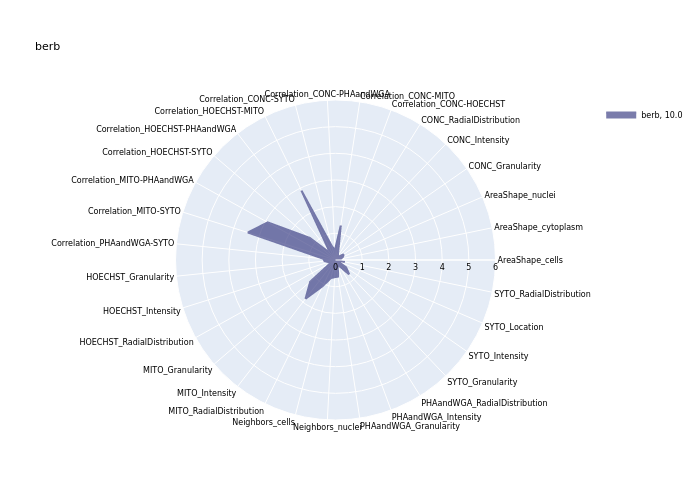

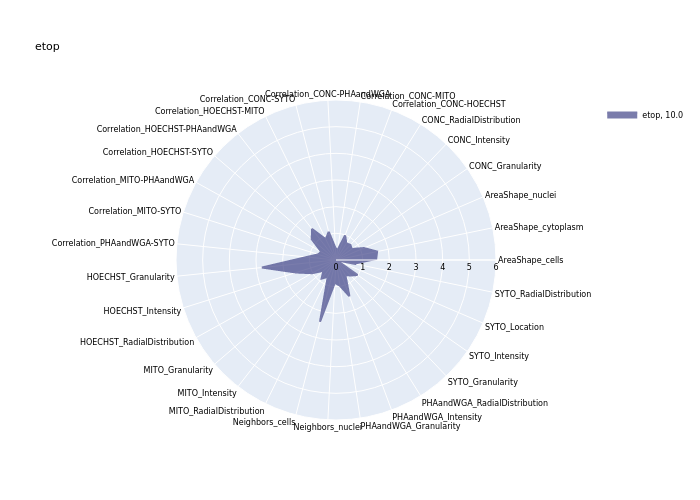

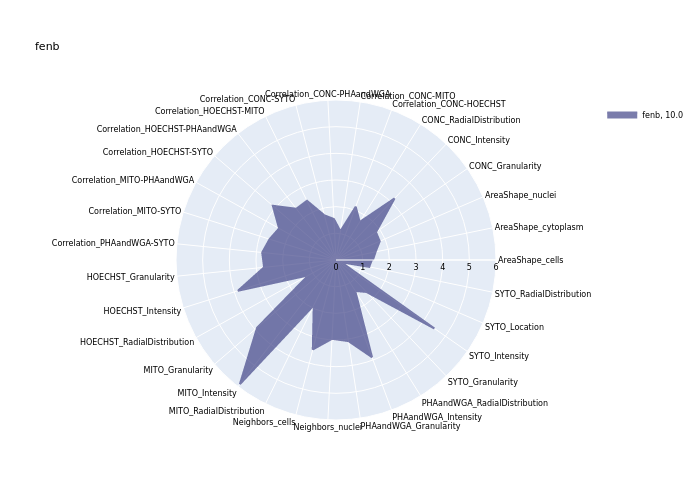

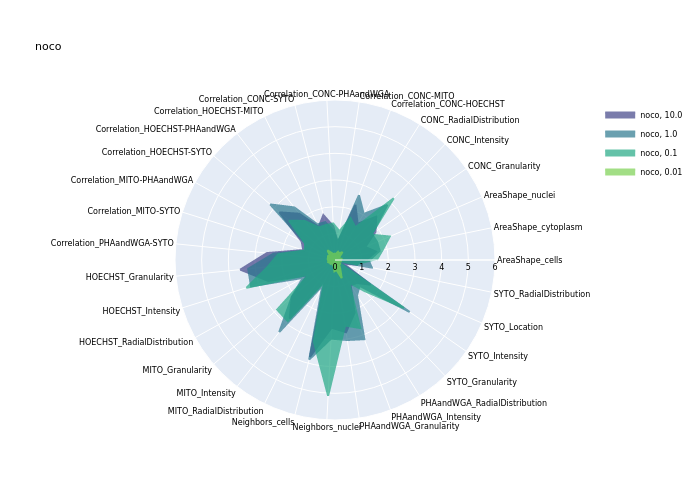

In [26]:
# plot radar plots

plot_colors = sns.color_palette(cmap, max_colors).as_hex()

for comp in selected_conditions:
    
    df_current = df_38cat[df_38cat[grouping_col] == comp].copy()
    compound_doses = sorted(set(df_current[secondary_grouping_col]), reverse=True)

    plot_traces = []

    for idx, dose in enumerate(compound_doses[:max_colors]):
        try:
            # Assign color from palette
            plot_color = plot_colors[idx % len(plot_colors)]
            comp_dose_data = df_current.loc[f"{comp}_{dose}"]

            # Create radar plot traces (layers)
            radar_trace = go.Scatterpolar(
                r=comp_dose_data, theta=categories,
                fill='toself', opacity=0.7,
                line_color=plot_color, fillcolor=plot_color,
                connectgaps=True, name=f"{comp}, {dose}"
            )
            plot_traces.append(radar_trace)
        except KeyError:
            print(f"Data not available for {comp}_{dose}")


    radar_figure = go.Figure(data=plot_traces)
    radar_figure.update_layout(
        title_text=comp,
        polar={'radialaxis': {'visible': True, 'range': [0, range_max]}},
        font=dict(family="Arial, sans-serif", size=8, color="Black"),
        showlegend=True
    )

    radar_figure.show(renderer='png')
    radar_figure.write_image(f"{OutputDir}/radarplot_compound_{comp}.png")


# end #